<a href="https://colab.research.google.com/github/bishnuparajuli024/Customer-RFM-Segmentation/blob/main/customer_segmentation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00


In [5]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
df = pd.read_excel('https://github.com/fenago/datasets/raw/main/Online%20Retail.xlsx')

In [7]:
print(df.head())
print(df.info())
print(df.describe())

# Data Preprocessing
df = df[df['Quantity'] > 0 ]
df = df[df['UnitPrice'] > 0]
df = df[~df['InvoiceNo'].str.contains("C",na=False)] # drop returned items

# Missing Values
print(df.dropna(inplace=True))

# Handling Outliers
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')

  InvoiceNo StockCode                          Description  Quantity         InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    5419

In [9]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [11]:
# DO NOT RUN THIS CODE.  THIS IS JUST TO SHOW YOU HOW TO DO THIS MANUALLY
# Assuming `data` is our DataFrame after loading it as shown in the previous section.

# Recency: Calculate the number of days since the last purchase for each customer
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']
latest_purchase_date = df['InvoiceDate'].max()
df['Recency'] = (latest_purchase_date - df['InvoiceDate']).dt.days

In [15]:
# Frequency: Count the number of purchases per customer
frequency_df = df.groupby('CustomerID').InvoiceNo.nunique()

In [16]:
# Tenure: Calculate the number of days since the first purchase to the last purchase for each customer
tenure_df = df.groupby('CustomerID').InvoiceDate.agg(lambda x: (x.max() - x.min()).days)


In [17]:
# Monetary: Sum the total spend per customer
monetary_df = df.groupby('CustomerID').TotalSpend.sum()

In [18]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price',observation_period_end='2011-12-09')

In [19]:
clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times

In [20]:
clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,550.570000
12348.0,3.0,283.0,358.0,116.126667
12352.0,6.0,260.0,296.0,192.840000
12356.0,2.0,303.0,325.0,226.080000
12359.0,3.0,274.0,331.0,1495.650000


In [21]:
# Subsection: The Role of BG/NBD and Gamma-Gamma Models

# The BG/NBD and Gamma-Gamma models serve as advanced statistical methods that enhance the RFM framework, particularly in predicting CLV.

# BG/NBD Model: This model is designed to predict the future purchase behavior of customers based on their past purchase history (i.e., their ‘recency’ and ‘frequency’). It helps in forecasting how likely a customer is to make a purchase in the next period (or periods).
# Gamma-Gamma Model: While the BG/NBD model focuses on the purchase pattern, the Gamma-Gamma model is used to predict the monetary value of future transactions. This model is applied only to customers with repeat purchases, as it assumes that there is no relationship between the frequency and the monetary value of transactions.
# By combining these two models, businesses can predict not just when their customers will purchase next, but also how much they are likely to spend. This comprehensive view enables companies to calculate CLV with greater accuracy, which, in turn, informs more targeted and cost-effective marketing strategies.

# When we implement these models in a platform like Google Colab, we ensure that our analysis is not only robust but also replicable and shareable, allowing teams to collaborate on refining strategies and implementing insights drawn from the RFM analysis.

# BG/NBD
# The BG/NBD model, short for Beta Geometric/Negative Binomial Distribution model, serves as a sophisticated yet intuitive tool for predicting a customer’s future purchase behavior based on their past actions. This model primarily addresses the frequency and timing of a customer’s purchases, answering the key question: ‘How likely is a customer to make a purchase within a given period?’

# Underlying the model is the assumption that purchase opportunities follow a Poisson process with a customer-specific purchase rate, and each opportunity can lead to a purchase with a certain probability. It integrates two crucial aspects: one is the probability of a transaction occurring within a specific time (that’s where the Negative Binomial Distribution part comes in), and the other is the probability of a customer becoming inactive or ‘dying’ (hence the Beta Geometric part). The BG/NBD model elegantly combines these two probabilities to forecast the number of future purchases a customer will make within a certain timeframe.

# What makes the BG/NBD model particularly valuable is its ability to accommodate variability in customer behavior without overcomplicating the estimation process. It allows for a personalized prediction of purchase patterns by considering each customer’s unique transaction history, which includes how recently and how often they have purchased. By factoring in the chances of a customer dropping off the radar, the model provides businesses with a dynamic and nuanced view of customer engagement. Consequently, companies can leverage this model to identify which customers to focus on retaining and how to allocate resources effectively to maximize customer lifetime value.

# Let’s use the BG/NBD Model for Predicting the Number of Purchases:

In [22]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1916 subjects, a: 0.00, alpha: 109.98, b: 0.00, r: 2.35>

In [23]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.352230e+00,9.460913e-02,2.166796e+00,2.537663e+00
alpha,1.099756e+02,4.886129e+00,1.003987e+02,1.195524e+02
a,7.059485e-17,2.153800e-11,-4.221440e-11,4.221454e-11
b,1.185774e-06,3.617539e-01,-7.090364e-01,7.090388e-01


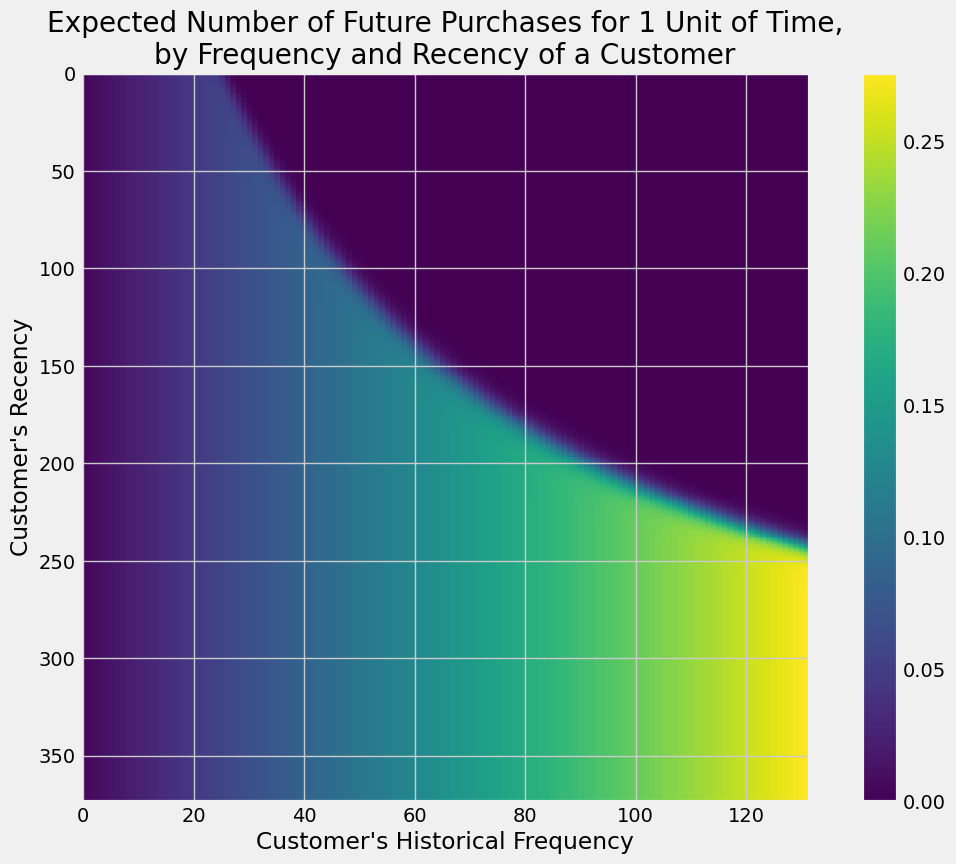

In [24]:
plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()

In [25]:
# Here’s how to read and understand this diagram:

# The Axes:
# The horizontal axis (X-axis) represents the ‘Customer’s Historical Frequency’, which is the total number of purchases a customer has made over a certain period. The values increase as you move right on the axis.
# The vertical axis (Y-axis) denotes the ‘Customer’s Recency’, measured in units of time (such as days). It represents the time since the customer’s last purchase. The values decrease as you move up the axis, meaning that a customer at the top of the map has made a purchase more recently than a customer at the bottom.
# Color Gradient:
# The color gradient on the right side represents the scale of expected future purchases. Warmer colors (like yellow) indicate a higher number of expected purchases, while cooler colors (like purple) indicate fewer expected purchases.
# Interpreting the Colors:
# Looking at the map, you can see that there is a transition from purple to yellow as you move from the top-left to the bottom-right. This suggests that customers with higher frequency (more purchases) but lower recency (more time since the last purchase) are expected to make more purchases in the future compared to those with lower frequency and higher recency.
# Business Insights:
# For business strategy, this map suggests that engaging customers who have purchased frequently in the past, even if some time has elapsed since their last purchase, could still be valuable. These customers have demonstrated loyalty and may respond well to re-engagement efforts.
# Conversely, customers with recent purchases but low frequency might not be as likely to purchase again in the near future, indicating that they might need different marketing strategies to encourage more frequent engagement.
# This heat map is a powerful tool for visualizing complex interactions between variables and can be very useful for businesses looking to optimize their marketing strategies based on customer purchase patterns.

# Now let’s predict the number of purchases in 6 Months:



In [26]:
t = 180 # 30 day period
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)


,frequency,recency,T,monetary_value,expected_purc_6_months
CustomerID,,,,,
14911.0,131.0,372.0,373.0,917.278855,49.698999
12748.0,112.0,373.0,373.0,257.314911,42.617895
17841.0,111.0,372.0,373.0,349.079640,42.245205
15311.0,89.0,373.0,373.0,421.881573,34.046032
14606.0,88.0,372.0,373.0,125.302955,33.673343


In [27]:
t = 360
clv['expected_purc_12_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_12_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months
CustomerID,,,,,,
14911.0,131.0,372.0,373.0,917.278855,49.698999,99.397997
12748.0,112.0,373.0,373.0,257.314911,42.617895,85.235790
17841.0,111.0,372.0,373.0,349.079640,42.245205,84.490410
15311.0,89.0,373.0,373.0,421.881573,34.046032,68.092065
14606.0,88.0,372.0,373.0,125.302955,33.673343,67.346685


In [29]:
# Gamma-Gamma
# The Gamma-Gamma model is a statistical approach used to estimate the monetary value of future transactions for customers in a given period. The name “Gamma-Gamma” derives from the statistical distributions it assumes for two key customer behaviors: the frequency of transactions and the monetary value of those transactions. Specifically, the model presumes that the monetary value of a customer’s transactions is distributed across a gamma distribution, independent of the transaction’s frequency.

# Here’s where it gets practical: The Gamma-Gamma model is applied to customers with repeat transactions, under the assumption that there’s no relationship between how often customers buy and how much they spend. This model takes into account the observed average transaction value and the variation in transaction value for each customer. By fitting a gamma distribution to these values, the model can predict the expected average monetary value of future transactions for each customer. This prediction, when combined with the customer’s expected purchase frequency from a model like BG/NBD, allows businesses to calculate a more accurate Customer Lifetime Value (CLV). The beauty of the Gamma-Gamma model is its ability to hone in on the “monetary” aspect of CLV, providing businesses with valuable insights into not just when customers will buy, but also how much they are likely to spend.

# The Gamma-Gamma submodel is based on a critical assumption: there is no correlation between the monetary value and the frequency of purchase.



In [30]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.110771
monetary_value,0.110771,1.000000


In [32]:
# Now that we know that there is no relationship, we can create our model:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1916 subjects, p: 3.79, q: 0.34, v: 3.72>

In [33]:
# How much will each customer generate us in revenue in 6 Months:
clv['6_Months_CLV']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)

In [34]:
clv.sort_values('6_Months_CLV',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months,6_Months_CLV
CustomerID,,,,,,,
14096.0,16.0,97.0,101.0,3012.454375,15.657745,31.315489,46062.314700
14911.0,131.0,372.0,373.0,917.278855,49.698999,99.397997,44093.511057
14646.0,44.0,353.0,354.0,2507.804091,17.982416,35.964832,43732.700984
14156.0,42.0,362.0,371.0,1366.275476,16.598352,33.196703,21996.982767
18102.0,25.0,367.0,367.0,2112.843200,10.322125,20.644250,21214.008259


In [35]:
# Now, let’s segment these customers:

clv['Segment'] =  pd.qcut(clv['6_Months_CLV'],4,labels = ['Hibernating','Need Attention',
                                                          'Loyal Customers','Champions'])

In [36]:
# Let’s look at where we are:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months,6_Months_CLV
Segment,,,,,,,
Hibernating,3.169102,220.565762,291.824635,148.661593,2.552501,5.105003,369.465054
Need Attention,4.018789,239.442589,282.941545,270.869214,3.004030,6.008060,763.560023
Loyal Customers,5.682672,241.569937,273.110647,369.673664,3.834613,7.669226,1276.982217
Champions,11.244259,264.486430,284.411273,636.264425,6.007552,12.015105,3416.144496


In [37]:
# Section 4: Implementing RFM Analysis in Diverse Sectors
# RFM analysis has been implemented across various industries to segment customers and drive business strategies. Here are a couple of examples demonstrating its application:

# Fuel Industry: In the fuel industry, RFM analysis was applied to segment customers for a fuel company. This segmentation allowed the company to understand customer needs better and tailor services accordingly. They were able to create strategies for different customer segments based on common features derived from RFM analysis. This type of targeted marketing helps in improving services and aligning them with customer expectations​​.
# Banking Industry: In the banking sector, CLV and RFM models have been used to analyze and manage customer relationships more effectively. The banking industry often uses customer data to drive marketing strategies and maximize revenue. These models help in understanding profitable customers and focusing management efforts to maintain them, ultimately increasing loyalty and customer profitability​​.
# E-commerce: RFM analysis is particularly impactful in e-commerce. For example, it was found that the top 5% of customers could spend ten times more than others, contributing significantly to total revenue. E-commerce businesses utilize RFM to target marketing campaigns toward high-value customers and adjust customer acquisition strategies accordingly. This targeting leads to more focused efforts in finding new customers that exhibit behaviors similar to the high-value segment, optimizing marketing spend and potentially increasing conversions and ROI. Tools that integrate with e-commerce platforms, like Shopify’s Segments, can automate this customer segmentation process, making it more accessible for businesses to apply RFM analysis to their customer data​​.
# These real-world implementations show that when used effectively, RFM analysis can be a powerful tool to not only understand customer behavior but also to enhance customer experience, engagement, and response rates across a variety of sectors. It emphasizes the importance of focusing on customer value and devising strategies for retention and acquisition that are informed by data-driven insights.


In [38]:
# Gaining Insights and Driving Strategy
# Interpreting the results of RFM analysis requires a thorough understanding of what each segment represents in terms of customer engagement and potential value. For instance, customers with high recency, frequency, and monetary values are your most valuable — often labeled as ‘Champions.’ These are the customers who have bought recently, buy often, and spend the most. Conversely, customers with low scores across RFM are at the risk of churning and may need re-engagement strategies.

# Armed with this knowledge, businesses can devise targeted strategies. For high-value segments, personalized attention and rewards programs are effective in enhancing loyalty. For those with lower scores, especially in recency and frequency, re-engagement campaigns with special offers can be useful. The insights gained can also drive product development, inventory management, and customer service approaches.

In [39]:
# Conclusion
# RFM analysis stands as a testament to the power of data in contemporary business practices. With its ability to segment customers into actionable groups based on their purchasing behavior, RFM analysis is a tool that has universal applicability, offering benefits like improved customer engagement, increased retention rates, and optimized marketing spend. This strategic approach allows businesses to not just respond to their market but to anticipate and shape customer behavior proactively.